---

**Matteo Serafino**   
**Date:** June 26, 2025  
**Email:** [matteo.serafino191@gmail.com](mailto:matteo.serafino191@gmail.com)

---
This notebook contains the analysis for: "Cognitive distortions are associated with increasing political polarization" by Andy Edinger, Johan Bollena, Hernán A. Makse, and Matteo Serafino.
---


In [23]:
# Core libraries
import pandas as pd
import numpy as np
import json

# Progress bar for loops
from tqdm import tqdm

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter
from brokenaxes import brokenaxes

# Statistical tests and signal processing
import scipy.stats as stats
from scipy.stats import ttest_ind, ttest_rel
from scipy.signal import find_peaks

# Statsmodels for regression and smoothing
from statsmodels.nonparametric.smoothers_lowess import lowess
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.sm_exceptions import ConvergenceWarning

# Suppress specific warnings for cleaner output
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.simplefilter("ignore", ConvergenceWarning)

In [2]:
def summarize_fixed_effects(data, model, outcome_col='prevalence', group_col='account_id'):
    print(f"\n--- Effect Size Summary ---")

    y_sd = data[outcome_col].std()
    df_approx = data[group_col].nunique() - len(model.fe_params)

    for param in model.fe_params.index:
        beta = model.fe_params[param]
        se = model.bse[param]
        pval = model.pvalues[param]
        ci_low, ci_high = model.conf_int().loc[param]

        # Binary contrasts
        if '[' in param:
            if param.startswith('year'):
                g1 = data[data['year'] == 2016][outcome_col]
                g2 = data[data['year'] == 2020][outcome_col]
            elif param.startswith('group'):
                g1 = data[data['group'] == 'left'][outcome_col]
                g2 = data[data['group'] == 'right'][outcome_col]
            else:
                g1 = g2 = None

            if g1 is not None and g2 is not None:
                n1, n2 = len(g1), len(g2)
                s1, s2 = g1.std(), g2.std()
                pooled_sd = np.sqrt(((n1 - 1)*s1**2 + (n2 - 1)*s2**2) / (n1 + n2 - 2))
                d = beta / pooled_sd
                print(f"{param}: β({df_approx}) = {beta:.3f}, p = {pval:.4g}, d = {d:.2f}, 95% CI [{ci_low:.3f}, {ci_high:.3f}]")
            else:
                print(f"{param}: β({df_approx}) = {beta:.3f}, p = {pval:.4g}, 95% CI [{ci_low:.3f}, {ci_high:.3f}]")

        # Continuous predictors (including quadratic)
        else:
            x_sd = data[param].std() if param in data.columns else None
            if x_sd:
                beta_star = beta * (x_sd / y_sd)
                print(f"{param}: β({df_approx}) = {beta:.3f}, p = {pval:.4g}, β* = {beta_star:.2f}, 95% CI [{ci_low:.3f}, {ci_high:.3f}]")
            else:
                print(f"{param}: β({df_approx}) = {beta:.3f}, p = {pval:.4g}, 95% CI [{ci_low:.3f}, {ci_high:.3f}]")


# Upload Data

### Raw data

In [3]:
# Load distortion data and ensure ID is string
users_distortion = pd.read_csv('user_cds.csv')
users_distortion['user_id'] = users_distortion['user_id'].astype(str)

# Load ideology estimates for 2016 and 2020, ensure IDs are string
users_ideology_2016 = pd.read_csv('ideology_estimates_2016_paper.csv')
users_ideology_2016['account_id'] = users_ideology_2016['account_id'].astype(str)

users_ideology_2020 = pd.read_csv('ideology_estimates_2020_paper.csv')
users_ideology_2020['account_id'] = users_ideology_2020['account_id'].astype(str)

# Get overlapping user IDs
overlapping_ids = set(users_ideology_2016['account_id']) & \
                  set(users_ideology_2020['account_id']) & \
                  set(users_distortion['user_id'])

print(f"Number of overlapping users: {len(overlapping_ids)}")

# Filter datasets to only overlapping users
users_ideology_2016 = users_ideology_2016[users_ideology_2016['account_id'].isin(overlapping_ids)]
users_ideology_2020 = users_ideology_2020[users_ideology_2020['account_id'].isin(overlapping_ids)]
users_distortion = users_distortion[users_distortion['user_id'].isin(overlapping_ids)].copy()
users_distortion.rename(columns={'user_id': 'account_id'}, inplace=True)

# Merge ideology and distortion data for each year
temp_2016 = pd.merge(users_ideology_2016, users_distortion, on='account_id')
temp_2020 = pd.merge(users_ideology_2020, users_distortion, on='account_id')

# Keep and rename relevant columns
temp_2016 = temp_2016[['account_id', 'est', '2016_distortion', '2016_total', '2016_prevalence']]
temp_2016.columns = ['account_id', 'polarization', 'distortion', 'total', 'prevalence']
temp_2016['year'] = 2016

temp_2020 = temp_2020[['account_id', 'est', '2020_distortion', '2020_total', '2020_prevalence']]
temp_2020.columns = ['account_id', 'polarization', 'distortion', 'total', 'prevalence']
temp_2020['year'] = 2020

# Combine into a long-format dataset
long_dataset = pd.concat([temp_2016, temp_2020])
long_dataset['year'] = long_dataset['year'].astype('category')

Number of overlapping users: 53493


### Define degree of polarization

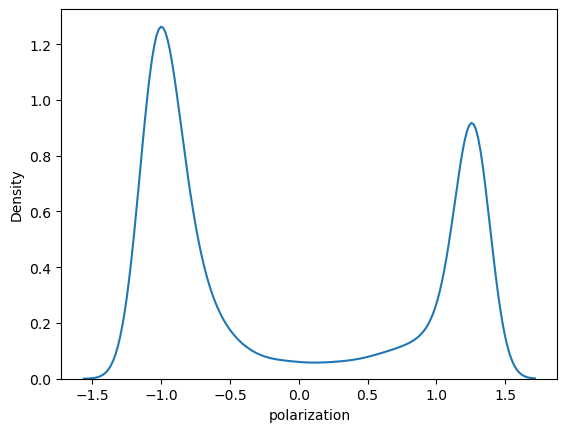

In [4]:
def find_peaks_above_threshold(data, threshold=0.1, plot=False):
    """
    Finds peaks in the KDE of the data that are above a certain threshold.

    Parameters:
    data (array-like): The input data for which KDE peaks are found.
    threshold (float): Minimum height for a peak to be considered.
    plot (bool): If True, plot the KDE. If False, only find peaks.

    Returns:
    array-like: X positions of the peaks above the threshold.
    """
    # Create KDE plot using Seaborn
    sns.kdeplot(data)

    # Get the data from the plot
    x_values = plt.gca().get_lines()[0].get_xdata()
    kde_values = plt.gca().get_lines()[0].get_ydata()

    if not plot: 
        # Close the plot
        plt.close()

    # Find peaks above the threshold in the KDE curve
    peaks, _ = find_peaks(kde_values, height=threshold)

    # Return x positions of the peaks
    return x_values[peaks]


# Function to compute polarization
def compute_polarization(latent_ideology, year):
    if year == 2016:
        if latent_ideology < 0:
            return abs(latent_ideology - peak_left_2016) / abs(peak_left_2016)
        else:
            return abs(latent_ideology - peak_right_2016) / abs(peak_right_2016)
    elif year == 2020:
        if latent_ideology < 0:
            return abs(latent_ideology - peak_left_2020) / abs(peak_left_2020)
        else:
            return abs(latent_ideology - peak_right_2020) / abs(peak_right_2020)
            
merged_df_ = long_dataset.copy()
peaks_2020 = find_peaks_above_threshold(merged_df_[merged_df_.year==2020]['polarization'])
peaks_2016 = find_peaks_above_threshold(merged_df_[merged_df_.year==2016]['polarization'],plot=True)

peak_right_2016 = peaks_2016[1]
peak_left_2016 = peaks_2016[0]

peak_right_2020 = peaks_2020[1]
peak_left_2020 = peaks_2020[0]


# Apply function to data
long_dataset['polarization_distance'] = 1-long_dataset.apply(lambda row: compute_polarization(row['polarization'], row['year']), axis=1)

# CDS prevalence \& latent ideology 


## Main

In [5]:
# Calculate average ideology per user per year
ideology = long_dataset.groupby(['account_id', 'year'])['polarization'].mean().unstack()
ideology.columns = ['polarization_2016', 'polarization_2020']

# Classify users based on consistent ideology
ideology['group'] = np.where(
    (ideology['polarization_2016'] < -0.5) & (ideology['polarization_2020'] < -0.5), 'left',
    np.where(
        (ideology['polarization_2016'] > 0.5) & (ideology['polarization_2020'] > 0.5), 'right',
        'center'
    )
)

# Merge group info and filter to consistent left/right users
long_dataset = long_dataset.merge(ideology[['group']], on='account_id')
data_filtered = long_dataset[long_dataset['group'].isin(['left', 'right'])]

# Split into left and right groups
data_left = data_filtered[data_filtered['group'] == 'left']
print(data_left['account_id'].nunique())

data_right = data_filtered[data_filtered['group'] == 'right']
print(data_right['account_id'].nunique())

# Get balanced sample size
sample_size = min(data_left['account_id'].nunique(), data_right['account_id'].nunique())

29048
18631


In [6]:
# --- Fit mixed-effects models --------------------------------------------------
model_left = smf.mixedlm(
    "prevalence ~ year + polarization_distance", 
    data_left, 
    groups=data_left["account_id"]
).fit()

model_right = smf.mixedlm(
    "prevalence ~ year + polarization_distance", 
    data_right, 
    groups=data_right["account_id"]
).fit()

# --- Print summaries and full effect sizes -------------------------------------
print("--- Left-leaning users ---\n")
print(model_left.summary())
summarize_fixed_effects(data_left, model_left)

print("\n--- Right-leaning users ---\n")
print(model_right.summary())
summarize_fixed_effects(data_right, model_right)


--- Left-leaning users ---

             Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   prevalence
No. Observations:    58096     Method:               REML      
No. Groups:          29048     Scale:                0.0086    
Min. group size:     2         Log-Likelihood:       44056.8468
Max. group size:     2         Converged:            Yes       
Mean group size:     2.0                                       
---------------------------------------------------------------
                      Coef. Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept             0.151    0.005 28.921 0.000  0.140  0.161
year[T.2020]          0.082    0.001 91.803 0.000  0.080  0.084
polarization_distance 0.066    0.006 11.357 0.000  0.055  0.077
Group Var             0.005    0.001                           


--- Effect Size Summary ---
Intercept: β(29045) = 0.151, p = 6.587e-184, 95% CI [0.140,

## Supplemetary Tables

### Activity as covariate

In [10]:
# --- Fit models --------------------------------------------------------------
model_left = smf.mixedlm(
    "prevalence ~ year + polarization_distance + total", 
    data_left, 
    groups=data_left["account_id"]
).fit()

model_right = smf.mixedlm(
    "prevalence ~ year + polarization_distance + total", 
    data_right, 
    groups=data_right["account_id"]
).fit()

# --- Summarize models --------------------------------------------------------
print("\n--- Left-leaning users ---")
print(model_left.summary())
summarize_fixed_effects(data_left, model_left)

print("\n--- Right-leaning users ---")
print(model_right.summary())
summarize_fixed_effects(data_right, model_right)



--- Left-leaning users ---
              Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    prevalence
No. Observations:    58096      Method:                REML      
No. Groups:          29048      Scale:                 0.0086    
Min. group size:     2          Log-Likelihood:        44156.5142
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                      Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept              0.150    0.005  28.905 0.000  0.140  0.160
year[T.2020]           0.082    0.001  91.528 0.000  0.080  0.083
polarization_distance  0.069    0.006  11.909 0.000  0.058  0.081
total                 -0.000    0.000 -15.019 0.000 -0.000 -0.000
Group Var              0.005    0.001                         

### Interaction Model

In [11]:
import statsmodels.formula.api as smf

# Fit model with interaction
model_interaction = smf.mixedlm(
    "prevalence ~ year + group + year:group + polarization_distance",
    data_filtered,
    groups=data_filtered["account_id"]
).fit()

# Print model summary
print(model_interaction.summary())

# Call your existing summary function
summarize_fixed_effects(data_filtered, model_interaction)


                 Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      prevalence
No. Observations:      95358        Method:                  REML      
No. Groups:            47679        Scale:                   0.0088    
Min. group size:       2            Log-Likelihood:          70533.5727
Max. group size:       2            Converged:               Yes       
Mean group size:       2.0                                             
-----------------------------------------------------------------------
                            Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------
Intercept                    0.174    0.004  44.452 0.000  0.167  0.182
year[T.2020]                 0.084    0.001  99.069 0.000  0.082  0.085
group[T.right]              -0.013    0.001 -11.223 0.000 -0.015 -0.011
year[T.2020]:group[T.right]  0.007    0.001   5.266 0.000  0.004  0.009
polarizat

### Sampling

In [12]:
n_iterations = 50

left_coefs, left_pvals = [], []
right_coefs, right_pvals = [], []

for i in tqdm(range(n_iterations)):
    # Subsample
    left_sample = data_left.sample(n=sample_size, random_state=i)
    right_sample = data_right.sample(n=sample_size, random_state=i)

    # LEFT model
    model_left = smf.mixedlm(
        "prevalence ~ year + polarization_distance",
        data=left_sample,
        groups=left_sample["account_id"]
    ).fit()

    left_coefs.append(model_left.params)
    left_pvals.append(model_left.pvalues)

    # RIGHT model
    model_right = smf.mixedlm(
        "prevalence ~ year + polarization_distance",
        data=right_sample,
        groups=right_sample["account_id"]
    ).fit()

    right_coefs.append(model_right.params)
    right_pvals.append(model_right.pvalues)

# Convert to DataFrames
left_coef_df = pd.DataFrame(left_coefs)
left_pval_df = pd.DataFrame(left_pvals)
right_coef_df = pd.DataFrame(right_coefs)
right_pval_df = pd.DataFrame(right_pvals)

#Summary stats
def summarize(df):
    return df.agg(['mean', 'std', lambda x: (x < 0.05).mean() * 100]).T.rename(columns={
        'mean': 'Mean',
        'std': 'SD',
        '<lambda_0>': '% p < 0.05'
    })

left_summary = summarize(left_coef_df).add_suffix(' (Coef Left)')
right_summary = summarize(right_coef_df).add_suffix(' (Coef Right)')
left_pval_summary = summarize(left_pval_df).add_suffix(' (p Left)')
right_pval_summary = summarize(right_pval_df).add_suffix(' (p Right)')

# Combine everything
summary_table = pd.concat([left_summary, left_pval_summary, right_summary, right_pval_summary], axis=1)

100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [19:23<00:00, 23.28s/it]


In [13]:
summary_table

,Mean (Coef Left),SD (Coef Left),<lambda> (Coef Left),Mean (p Left),SD (p Left),<lambda> (p Left),Mean (Coef Right),SD (Coef Right),<lambda> (Coef Right),Mean (p Right),SD (p Right),<lambda> (p Right)
Intercept,0.120600,0.006605,0.0,3.687619e-32,1.971726e-31,100.0,0.184142,0.006651,0.0,1.801409e-83,1.225668e-82,100.0
year[T.2020],0.079283,0.001726,0.0,0.000000e+00,0.000000e+00,100.0,0.091851,0.001160,0.0,0.000000e+00,0.000000e+00,100.0
polarization_distance,0.099753,0.007536,0.0,1.563134e-16,9.245907e-16,100.0,0.014494,0.007159,100.0,2.129362e-01,2.065380e-01,30.0
Group Var,0.608874,0.041272,0.0,9.976731e-48,5.423356e-47,100.0,0.707948,0.027498,0.0,3.846114e-91,2.184809e-90,100.0


# CDS prevalence vs. latent ideology.

### Compute Delta_P and Delta_CDS

In [14]:
merged_df_ = data_filtered.copy()
polarization_wide = merged_df_.pivot(index='account_id', columns='year', values='polarization_distance').reset_index()
polarization_wide.columns = ['account_id', 'l_2016', 'l_2020']

# Compute ΔP
polarization_wide['delta_P'] = polarization_wide['l_2020'] - polarization_wide['l_2016']

# Merge delta_P back into long format data
merged_df_ = merged_df_.merge(polarization_wide[['account_id', 'delta_P']], on='account_id')

# Pivot condition_status to wide format
cds_wide = merged_df_.pivot(index='account_id', columns='year', values='prevalence').reset_index()
cds_wide.columns = ['account_id', 'CDS_2016', 'CDS_2020']

# Compute r(CDS)
cds_wide['delta_CDS'] = cds_wide['CDS_2020'] - cds_wide['CDS_2016']

# Merge datasets
merged_df_ = merged_df_.merge(cds_wide, on='account_id')

## Main

In [15]:
def select_moderate_users(df, est_col, neg_peak, pos_peak, threshold):
    """
    Select users whose estimated polarization falls between two peaks, 
    excluding extreme partisans with a threshold buffer.
    """
    return df[
        (df[est_col] > neg_peak + threshold) &
        (df[est_col] < pos_peak - threshold)
    ].copy()

# Apply to 2016 users only
middle_users_2016 = select_moderate_users(
    df=merged_df_[merged_df_.year == 2016],
    est_col='polarization',
    neg_peak=peak_left_2016,
    pos_peak=peak_right_2016,
    threshold=0.2
)

print(f"Selected {len(middle_users_2016)} moderate users.")

# Extract full data (both years) for these selected users
temporal = merged_df_[merged_df_.account_id.isin(middle_users_2016.account_id)]


Selected 7318 moderate users.


In [16]:
# --- Mixed model with time-varying polarization and user-level delta_P ---
model_mixed = smf.mixedlm(
    "prevalence ~ year + group + delta_P",
    temporal,
    groups=temporal["account_id"]
).fit()

# Print the model summary
print(model_mixed.summary())
# Run the summary
summarize_fixed_effects(temporal, model_mixed)


         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: prevalence
No. Observations: 14636   Method:             REML      
No. Groups:       7318    Scale:              0.0080    
Min. group size:  2       Log-Likelihood:     11356.4646
Max. group size:  2       Converged:          Yes       
Mean group size:  2.0                                   
--------------------------------------------------------
               Coef. Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept      0.167    0.003 59.794 0.000  0.162  0.173
year[T.2020]   0.076    0.001 51.613 0.000  0.073  0.079
group[T.right] 0.015    0.002  6.505 0.000  0.011  0.020
delta_P        0.062    0.009  6.949 0.000  0.045  0.080
Group Var      0.006    0.002                           


--- Effect Size Summary ---
Intercept: β(7314) = 0.167, p = 0, 95% CI [0.162, 0.173]
year[T.2020]: β(7314) = 0.076, p = 0, d = 0.65, 95% CI [0.073, 0.079

/tmp/ipykernel_7989/1775971060.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temporal['delta_P_bin'] = pd.qcut(
/tmp/ipykernel_7989/1775971060.py:68: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


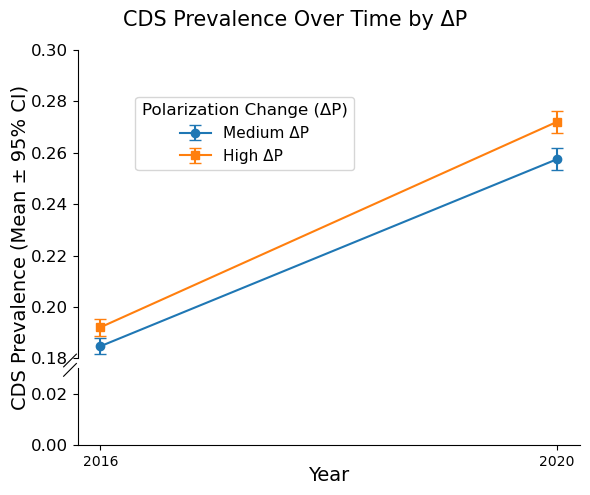

In [24]:

# --- Step 1: Bin delta_P ---
temporal['delta_P_bin'] = pd.qcut(
    temporal['delta_P'], q=2, labels=['Medium ΔP', 'High ΔP']
)

# --- Step 2: Compute summary stats ---
summary = (
    temporal.groupby(['year', 'delta_P_bin'])['prevalence']
    .agg(['mean', 'count', 'std'])
    .reset_index()
)
summary['ci95'] = 1.96 * (summary['std'] / np.sqrt(summary['count']))
summary['year'] = summary['year'].astype(int)  # Ensure year is integer

# --- Step 3: Fill missing combinations (2016/2020 + ΔP bins) ---
for year in [2016, 2020]:
    for label in ['Medium ΔP', 'High ΔP']:
        if not ((summary['year'] == year) & (summary['delta_P_bin'] == label)).any():
            summary = pd.concat([summary, pd.DataFrame({
                'year': [year],
                'delta_P_bin': [label],
                'mean': [np.nan],
                'count': [0],
                'std': [np.nan],
                'ci95': [np.nan]
            })], ignore_index=True)

# --- Step 4: Plot with brokenaxes ---
fig = plt.figure(figsize=(6, 5))
bax = brokenaxes(ylims=((0, 0.03), (0.18, 0.3)), hspace=0.05)

colors = {'Medium ΔP': 'tab:blue', 'High ΔP': 'tab:orange'}
markers = {'Medium ΔP': 'o', 'High ΔP': 's'}

# --- Step 5: Plot data with lines and error bars ---
for label in ['Medium ΔP', 'High ΔP']:
    group = summary[summary['delta_P_bin'] == label].sort_values('year')
    bax.errorbar(
        group['year'], group['mean'], yerr=group['ci95'],
        fmt='-',
        marker=markers[label],
        label=label,
        color=colors[label],
        capsize=4,
        markersize=6
    )

# --- Step 6: Axis labels and ticks ---
bax.set_xlabel("Year", fontsize=14)
bax.set_ylabel("CDS Prevalence (Mean ± 95% CI)", fontsize=14,labelpad=35)

for ax in bax.axs:
    ax.set_xticks([2016, 2020])
    ax.set_xticklabels(['2016', '2020'])
    ax.tick_params(axis='y', labelsize=12)

# --- Step 7: Title and legend ---
bax.legend(
    title='Polarization Change (ΔP)',
    fontsize=11,
    title_fontsize=12,
    loc='upper left',
    bbox_to_anchor=(0.1, 0.9)  # Adjust x (leftward) and y (centered)
)
fig.suptitle("CDS Prevalence Over Time by ΔP", fontsize=15)

# --- Step 8: Save and show ---
plt.tight_layout()
plt.savefig("cvd_vs_dp_brokenaxes.pdf")
plt.show()



## SI


### Delta cds vs. DealtP.



In [25]:
# Mixed model with polarization as time-varying, delta_P as user-level
model_mixed = smf.mixedlm(
    "delta_CDS ~ year + group + delta_P",
    temporal,
    groups=temporal["account_id"]
).fit()

# Print the model summary
print(model_mixed.summary())
# Run the summary
summarize_fixed_effects(data=temporal, model=model_mixed, outcome_col='delta_CDS')


         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: delta_CDS 
No. Observations: 14636   Method:             REML      
No. Groups:       7318    Scale:              0.0000    
Min. group size:  2       Log-Likelihood:     92420.1973
Max. group size:  2       Converged:          Yes       
Mean group size:  2.0                                   
--------------------------------------------------------
               Coef. Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept      0.063    0.002 25.362 0.000  0.058  0.067
year[T.2020]   0.000    0.000  0.000 1.000 -0.000  0.000
group[T.right] 0.017    0.002  7.680 0.000  0.012  0.021
delta_P        0.031    0.008  3.785 0.000  0.015  0.047
Group Var      0.008   87.211                           


--- Effect Size Summary ---
Intercept: β(7314) = 0.063, p = 6.694e-142, 95% CI [0.058, 0.067]
year[T.2020]: β(7314) = 0.000, p = 1, d = 0.00, 95% CI [-0.

### Activity

In [26]:
# Mixed model with polarization as time-varying, delta_P as user-level
model_mixed = smf.mixedlm(
    "prevalence ~ year + group + delta_P + total",
    temporal,
    groups=temporal["account_id"]
).fit()

# Print the model summary
print(model_mixed.summary())
# Run the summary
summarize_fixed_effects(temporal, model_mixed, outcome_col='prevalence', group_col='account_id')


          Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: prevalence
No. Observations:  14636   Method:             REML      
No. Groups:        7318    Scale:              0.0080    
Min. group size:   2       Log-Likelihood:     11372.6487
Max. group size:   2       Converged:          Yes       
Mean group size:   2.0                                   
---------------------------------------------------------
               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept       0.170    0.003 60.521 0.000  0.164  0.175
year[T.2020]    0.076    0.001 51.597 0.000  0.074  0.079
group[T.right]  0.015    0.002  6.508 0.000  0.011  0.020
delta_P         0.063    0.009  7.032 0.000  0.045  0.080
total          -0.000    0.000 -7.528 0.000 -0.000 -0.000
Group Var       0.005    0.002                           


--- Effect Size Summary ---
Intercept: β(7313) = 0.170, p = 0, 95% CI [0.164, 0.

### No group

In [27]:
# Fit the mixed model
model_mixed = smf.mixedlm(
    "prevalence ~ year + delta_P",
    temporal,
    groups=temporal["account_id"]
).fit()

# Print model summary
print(model_mixed.summary())

# Summarize effect sizes
summarize_fixed_effects(temporal, model_mixed, outcome_col='prevalence', group_col='account_id')


         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: prevalence
No. Observations: 14636   Method:             REML      
No. Groups:       7318    Scale:              0.0080    
Min. group size:  2       Log-Likelihood:     11340.4922
Max. group size:  2       Converged:          Yes       
Mean group size:  2.0                                   
--------------------------------------------------------
               Coef. Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept      0.174    0.003 66.475 0.000  0.169  0.179
year[T.2020]   0.076    0.001 51.613 0.000  0.073  0.079
delta_P        0.059    0.009  6.557 0.000  0.041  0.076
Group Var      0.006    0.003                           


--- Effect Size Summary ---
Intercept: β(7315) = 0.174, p = 0, 95% CI [0.169, 0.179]
year[T.2020]: β(7315) = 0.076, p = 0, d = 0.65, 95% CI [0.073, 0.079]
delta_P: β(7315) = 0.059, p = 5.497e-11, β* = 0.06, 95%

## Main

In [28]:
# Fit mixed model with interaction between group and delta_P
model_interaction = smf.mixedlm(
    "prevalence ~ year + group + delta_P + group:delta_P",
    data=temporal,
    groups=temporal["account_id"]
).fit()

# Print model summary
print(model_interaction.summary())
# Summarize effect sizes
summarize_fixed_effects(temporal, model_interaction, outcome_col='prevalence', group_col='account_id')


              Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    prevalence
No. Observations:    14636      Method:                REML      
No. Groups:          7318       Scale:                 0.0080    
Min. group size:     2          Log-Likelihood:        11359.9532
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept               0.158    0.004 40.733 0.000  0.150  0.165
year[T.2020]            0.076    0.001 51.613 0.000  0.073  0.079
group[T.right]          0.032    0.005  6.244 0.000  0.022  0.042
delta_P                 0.100    0.014  7.273 0.000  0.073  0.127
group[T.right]:delta_P -0.066    0.018 -3.629 0.000 -0.101 -0.030
Group Var               

## SI

In [30]:
#sampling
right_group = temporal[temporal.group.isin(['right'])]
left_group = temporal[temporal.group.isin(['left'])]
n_reps = 10
sample_size = min(right_group.account_id.nunique(), left_group.account_id.nunique())
# Store results
coefs = []
pvals = []

for i in tqdm(range(n_reps)):
    # Subsample with replacement
    left_sample = left_group.sample(n=sample_size, random_state=i,replace=True)
    right_sample = right_group.sample(n=sample_size, random_state=i,replace=True)
    sample_df = pd.concat([left_sample,right_sample]).reset_index()
    
    try:
        # Fit the model on the subsample
        model = smf.mixedlm(
            "prevalence ~ year + group + delta_P + group:delta_P",
            data=sample_df,
            groups=sample_df["account_id"]
        ).fit()

        # Save coefficients and p-values
        coefs.append(model.params)
        pvals.append(model.pvalues)

    except Exception as e:
        print(f"Model failed on one iteration: {e}")
        continue

# Convert to DataFrames
coefs_df = pd.DataFrame(coefs)
pvals_df = pd.DataFrame(pvals)

# Compute means and stds
coef_summary = coefs_df.agg(['mean', 'std'])
pval_summary = pvals_df.agg(['mean', 'std'])

# Combine into a final summary
summary = pd.concat([coef_summary, pval_summary], keys=['Coef', 'P-value'])

summary

100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:38<00:00,  3.80s/it]


Intercept   year[T.2020]  group[T.right]   delta_P  \
Coef    mean   1.576132e-01   7.857493e-02        0.031033  0.095496   
        std    5.565663e-03   3.485268e-03        0.007499  0.018652   
P-value mean  6.415196e-111  7.520218e-187        0.003632  0.002576   
        std   2.021656e-110   0.000000e+00        0.009148  0.007591   

              group[T.right]:delta_P     Group Var  
Coef    mean               -0.061776  2.418736e+00  
        std                 0.022816  1.840767e-01  
P-value mean                0.093792  1.002924e-72  
        std                 0.160068  1.638705e-72

## Main

In [31]:
temporal["delta_P_squared"] = temporal["delta_P"] ** 2

model = smf.mixedlm(
    "prevalence ~ year + group + delta_P + delta_P_squared + group:delta_P + group:delta_P_squared",
    data=temporal,
    groups=temporal["account_id"]
).fit()

# Print model summary
print(model.summary())
# Summarize effect sizes
summarize_fixed_effects(temporal, model, outcome_col='prevalence')


/tmp/ipykernel_7989/863386337.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temporal["delta_P_squared"] = temporal["delta_P"] ** 2


                  Mixed Linear Model Regression Results
Model:                   MixedLM      Dependent Variable:      prevalence
No. Observations:        14636        Method:                  REML      
No. Groups:              7318         Scale:                   0.0080    
Min. group size:         2            Log-Likelihood:          11358.4098
Max. group size:         2            Converged:               Yes       
Mean group size:         2.0                                             
-------------------------------------------------------------------------
                               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                       0.151    0.006 26.958 0.000  0.140  0.162
year[T.2020]                    0.076    0.001 51.613 0.000  0.073  0.079
group[T.right]                  0.039    0.007  5.973 0.000  0.026  0.052
delta_P                         0.166    0.043  3.831 0.

/tmp/ipykernel_7989/4248800028.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temporal['delta_P_c'] = temporal['delta_P'] - temporal['delta_P'].mean()
/tmp/ipykernel_7989/4248800028.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temporal['delta_P_c2'] = temporal['delta_P_c'] ** 2
/tmp/ipykernel_7989/4248800028.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

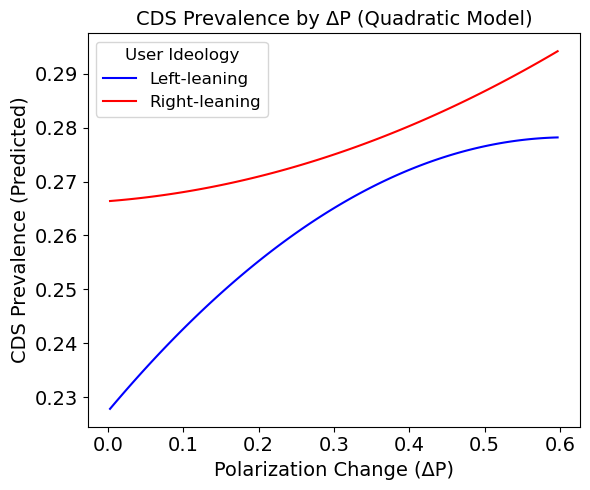

In [32]:
# --- Prepare data ---
temporal['delta_P_c'] = temporal['delta_P'] - temporal['delta_P'].mean()
temporal['delta_P_c2'] = temporal['delta_P_c'] ** 2
temporal['group'] = pd.Categorical(temporal['group'], categories=['left', 'right'])
temporal['year'] = temporal['year'].astype(str)

# --- Fit mixed effects model ---
model = smf.mixedlm(
    "prevalence ~ year + group + delta_P_c + delta_P_c2 + group:delta_P_c + group:delta_P_c2",
    data=temporal,
    groups=temporal["account_id"]
).fit()

# --- Prepare prediction data ---
delta_c = np.linspace(temporal["delta_P_c"].min(), temporal["delta_P_c"].max(), 200)
delta = delta_c + temporal["delta_P"].mean()
delta_c2 = delta_c ** 2

predict_df = pd.DataFrame({
    "delta_P_c": np.tile(delta_c, 2),
    "delta_P_c2": np.tile(delta_c2, 2),
    "group": ["left"] * len(delta_c) + ["right"] * len(delta_c),
    "year": "2020"
})
predict_df["group"] = pd.Categorical(predict_df["group"], categories=["left", "right"])
predict_df["pred"] = model.predict(predict_df)

# --- Filter predictions where ΔP >= 0 ---
mask = delta >= 0
delta = delta[mask]
pred_left = predict_df[predict_df["group"] == "left"]["pred"].values[mask]
pred_right = predict_df[predict_df["group"] == "right"]["pred"].values[mask]

# --- Plot ---
plt.figure(figsize=(6, 5))
plt.plot(delta, pred_left, label='Left-leaning', color='blue')
plt.plot(delta, pred_right, label='Right-leaning', color='red')
plt.title('CDS Prevalence by ΔP (Quadratic Model)', fontsize=14)
plt.xlabel('Polarization Change (ΔP)', fontsize=14)
plt.ylabel('CDS Prevalence (Predicted)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(title='User Ideology', fontsize=12, title_fontsize=12)
plt.tight_layout()
plt.grid(False)
plt.savefig('cds_ceiling_effect_plot.pdf')
plt.show()



# Temporal Link Between Polarization and CDS

In [33]:
# Extract values for 2016 and 2020
df_2016 = temporal[temporal['year'] == '2016'][['account_id', 'prevalence', 'polarization_distance']].rename(
    columns={'prevalence': 'prevalence_2016', 'polarization_distance': 'polarization_2016'}
)

df_2020 = temporal[temporal['year'] == '2020'][['account_id', 'prevalence', 'polarization_distance']].rename(
    columns={'prevalence': 'prevalence_2020', 'polarization_distance': 'polarization_2020'}
)

# Merge into a single DataFrame
df_lagged = pd.merge(df_2016, df_2020, on='account_id')

In [34]:
# MODEL A: Does polarization in 2016 predict CDS prevalence in 2020?
model_a = smf.mixedlm(
    "prevalence_2020 ~ polarization_2016",
    data=df_lagged,
    groups=df_lagged["account_id"]
).fit()

# MODEL B: Does CDS prevalence in 2016 predict polarization in 2020?
model_b = smf.mixedlm(
    "polarization_2020 ~ prevalence_2016",
    data=df_lagged,
    groups=df_lagged["account_id"]
).fit()

# Print summaries
print("--- Model A: CDS_2020 ~ Polarization_2016 ---")
print(model_a.summary())
summarize_fixed_effects(df_lagged, model_a, outcome_col='prevalence_2020')

print("\n--- Model B: Polarization_2020 ~ CDS_2016 ---")
print(model_b.summary())
summarize_fixed_effects(df_lagged, model_b, outcome_col='polarization_2020')


--- Model A: CDS_2020 ~ Polarization_2016 ---
            Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: prevalence_2020
No. Observations: 7318    Method:             REML           
No. Groups:       7318    Scale:              0.0086         
Min. group size:  1       Log-Likelihood:     4488.9595      
Max. group size:  1       Converged:          Yes            
Mean group size:  1.0                                        
-------------------------------------------------------------
                  Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept          0.284    0.001 271.766 0.000  0.282  0.286
polarization_2016 -0.028    0.001 -38.979 0.000 -0.029 -0.026
Group Var          0.009                                     


--- Effect Size Summary ---
Intercept: β(7316) = 0.284, p = 0, 95% CI [0.282, 0.286]
polarization_2016: β(7316) = -0.028, p = 0, β* = -0.02, 95% CI [-0.029, -

## SI

In [35]:
# Estimate the DiD model
temporal['treatment'] = (temporal['delta_P'] > 0).astype(int)

model_did = smf.mixedlm(
    "prevalence ~ year * treatment",
    data=temporal,
    groups=temporal["account_id"]
).fit()

# Print summary
print(model_did.summary())

# Compute and print effect sizes
summarize_fixed_effects(temporal, model_did, outcome_col='prevalence', group_col='account_id')


/tmp/ipykernel_7989/1974175562.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temporal['treatment'] = (temporal['delta_P'] > 0).astype(int)


             Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   prevalence
No. Observations:     14636     Method:               REML      
No. Groups:           7318      Scale:                0.0080    
Min. group size:      2         Log-Likelihood:       11316.5276
Max. group size:      2         Converged:            Yes       
Mean group size:      2.0                                       
----------------------------------------------------------------
                       Coef. Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept              0.180    0.007 25.055 0.000  0.166  0.194
year[T.2020]           0.072    0.008  9.273 0.000  0.057  0.087
treatment              0.009    0.007  1.208 0.227 -0.006  0.023
year[T.2020]:treatment 0.004    0.008  0.558 0.577 -0.011  0.020
Group Var              0.006    0.003                           


--- Effect Size Summary ---
Intercept

In [36]:
temporal['treatment'] = (temporal['delta_CDS'] > 0).astype(int)

model = smf.mixedlm(
    "polarization_distance ~ year * treatment",
    data=temporal,
    groups="account_id"
).fit()


# Print summary
print(model.summary())

# Compute and print effect sizes
summarize_fixed_effects(temporal, model, outcome_col='polarization_distance', group_col='account_id')


/tmp/ipykernel_7989/3590792877.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temporal['treatment'] = (temporal['delta_CDS'] > 0).astype(int)


               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: polarization_distance
No. Observations: 14636   Method:             REML                 
No. Groups:       7318    Scale:              0.0082               
Min. group size:  2       Log-Likelihood:     13462.4218           
Max. group size:  2       Converged:          Yes                  
Mean group size:  2.0                                              
-------------------------------------------------------------------
                        Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                0.685    0.002 308.072 0.000  0.681  0.690
year[T.2020]             0.242    0.003  82.387 0.000  0.236  0.248
treatment               -0.002    0.003  -0.963 0.335 -0.008  0.003
year[T.2020]:treatment   0.009    0.003   2.654 0.008  0.002  0.016
account_id Var           0.001    0.001                        